In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path
import os
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class ConfigStruct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [3]:
config = dict(
    epochs=600,
    batch_size=2048,
    learning_rate=0.008,
    weight_decay=1e-5,
    dropout=0.05,
    shuffle=True,
    nprocs_filter=True,
    nprocs="4_16_48_64_144_240",
    test_size=0.2,
    split_seed=42,
    random_seed=1234,
    stratified_split=True,
    smooth_l1_loss_beta=1.0
)

In [4]:
MODEL_FILENAME = "Model_A_(NProcs).pth"
MODEL_DIR = "../models"
MODEL_PATH = Path(MODEL_DIR, MODEL_FILENAME)

DATASET_DIR = "../data"
DATASET_NAME = "blue_waters_posix_no_outliers_4_16_48_64_144_240_nprocs"
DATASET_PATH = Path(DATASET_DIR, DATASET_NAME).with_suffix(".csv")

CSV_LOG_PATH = "../results/training/Model_A_(NProcs)_test_loss.csv"

In [5]:
if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "test_loss"])

In [6]:
df_blue_waters_posix = pd.read_csv(DATASET_PATH)
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,4870,-792,-792,216275,135216,205111,15951,0,1,-792,...,0.0,0.735744,1540420499,1540421012,48,514.0,3.1,./SpEC,1,46.554144
1,47864,-912,-912,1632215,145357,1064440,129731,0,1,-912,...,0.0,2.666620,1540485088,1540487684,48,2597.0,3.1,./SpEC,1,352.539247
2,6918,-897,-897,3414728,2916487,5434114,109523,0,1,-897,...,0.0,0.429495,1540414373,1540498945,48,84573.0,3.1,./SpEC,1,115.303713
3,6751,-874,-874,1081394,853013,1493947,61126,0,1,-874,...,0.0,0.598302,1540420003,1540442686,48,22684.0,3.1,./SpEC,1,232.904128
4,77666,-748,-748,2943105,296788,1873612,224671,0,1,-748,...,0.0,1.916454,1540447353,1540453286,48,5934.0,3.1,./SpEC,1,587.173510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349815,25004,-1288,-1288,3908646,3326772,5245647,468926,0,1,-1288,...,0.0,0.974784,1506621629,1506693654,48,72026.0,3.1,./SpEC,1,117.217110
349816,4870,-800,-800,216509,133294,204742,15981,0,1,-800,...,0.0,0.720533,1506609532,1506610004,48,473.0,3.1,./SpEC,1,37.922704
349817,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,0.0,0.914386,1506629880,1506630161,48,282.0,3.1,./SpEC,1,164.318747
349818,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,0.0,0.752825,1506647712,1506651237,48,3526.0,3.1,./SpEC,1,236.018095


In [7]:
# Remove all records with zero in the "bandwidth" column
df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix["bandwidth"] != 0]
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,4870,-792,-792,216275,135216,205111,15951,0,1,-792,...,0.0,0.735744,1540420499,1540421012,48,514.0,3.1,./SpEC,1,46.554144
1,47864,-912,-912,1632215,145357,1064440,129731,0,1,-912,...,0.0,2.666620,1540485088,1540487684,48,2597.0,3.1,./SpEC,1,352.539247
2,6918,-897,-897,3414728,2916487,5434114,109523,0,1,-897,...,0.0,0.429495,1540414373,1540498945,48,84573.0,3.1,./SpEC,1,115.303713
3,6751,-874,-874,1081394,853013,1493947,61126,0,1,-874,...,0.0,0.598302,1540420003,1540442686,48,22684.0,3.1,./SpEC,1,232.904128
4,77666,-748,-748,2943105,296788,1873612,224671,0,1,-748,...,0.0,1.916454,1540447353,1540453286,48,5934.0,3.1,./SpEC,1,587.173510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349815,25004,-1288,-1288,3908646,3326772,5245647,468926,0,1,-1288,...,0.0,0.974784,1506621629,1506693654,48,72026.0,3.1,./SpEC,1,117.217110
349816,4870,-800,-800,216509,133294,204742,15981,0,1,-800,...,0.0,0.720533,1506609532,1506610004,48,473.0,3.1,./SpEC,1,37.922704
349817,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,0.0,0.914386,1506629880,1506630161,48,282.0,3.1,./SpEC,1,164.318747
349818,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,0.0,0.752825,1506647712,1506651237,48,3526.0,3.1,./SpEC,1,236.018095


In [8]:
df_blue_waters_posix = df_blue_waters_posix.drop(["start_time_sec", "end_time_sec", "run_time", "log_ver", "exe", "lustre"], axis=1)
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_READ_TIME,POSIX_F_WRITE_TIME,POSIX_F_META_TIME,POSIX_TOTAL_TIME,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,nprocs,bandwidth
0,4870,-792,-792,216275,135216,205111,15951,0,1,-792,...,25.046999,0.000000,1.629810,26.676809,0.094352,0.172894,0.0,0.735744,48,46.554144
1,47864,-912,-912,1632215,145357,1064440,129731,0,1,-912,...,51.351125,0.000000,13.179558,64.530683,0.231165,0.196214,0.0,2.666620,48,352.539247
2,6918,-897,-897,3414728,2916487,5434114,109523,0,1,-897,...,37.727463,22.408341,5.001379,65.137183,0.312966,0.417510,0.0,0.429495,48,115.303713
3,6751,-874,-874,1081394,853013,1493947,61126,0,1,-874,...,19.203549,0.000000,1.630348,20.833897,0.164479,0.295684,0.0,0.598302,48,232.904128
4,77666,-748,-748,2943105,296788,1873612,224671,0,1,-748,...,70.755883,0.000000,11.499421,82.255303,0.197717,0.423445,0.0,1.916454,48,587.173510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349815,25004,-1288,-1288,3908646,3326772,5245647,468926,0,1,-1288,...,13.594173,93.287188,50.226209,157.107570,0.540237,0.333199,0.0,0.974784,48,117.217110
349816,4870,-800,-800,216509,133294,204742,15981,0,1,-800,...,27.897124,0.000000,1.937185,29.834308,0.100729,1.024560,0.0,0.720533,48,37.922704
349817,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,32.179977,0.000000,4.170172,36.350149,0.152006,0.266960,0.0,0.914386,48,164.318747
349818,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,23.145645,0.000000,2.337891,25.483536,0.118279,0.305436,0.0,0.752825,48,236.018095


In [9]:
# Separate bandwidth from input features
bandwidth_df = df_blue_waters_posix.pop('bandwidth')
bandwidth_df

0          46.554144
1         352.539247
2         115.303713
3         232.904128
4         587.173510
             ...    
349815    117.217110
349816     37.922704
349817    164.318747
349818    236.018095
349819    141.832395
Name: bandwidth, Length: 349192, dtype: float64

In [10]:
random.seed(config["random_seed"])
np.random.seed(config["random_seed"])

torch.manual_seed(config["random_seed"])
torch.cuda.manual_seed_all(config["random_seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
config = ConfigStruct(**config)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_blue_waters_posix,
                                                    bandwidth_df,
                                                    test_size=config.test_size,
                                                    random_state=config.split_seed,
                                                    stratify=df_blue_waters_posix["nprocs"] if config.stratified_split else None)

In [13]:
non_numeric_columns = X_train.select_dtypes(include='object').columns
non_numeric_columns

Index([], dtype='object')

In [14]:
X_train = X_train.drop(columns=non_numeric_columns)
X_train

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,rank,POSIX_F_READ_TIME,POSIX_F_WRITE_TIME,POSIX_F_META_TIME,POSIX_TOTAL_TIME,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,nprocs
42756,82355,-1246,-1246,3335255,1410107,2733878,444352,0,1,-1246,...,0,36.047856,79.555730,45.056015,160.659601,0.293052,1.493727,0.0,1.421895,48
50897,13017,-1563,-1563,3228755,2604239,4893544,167901,0,1,-1563,...,0,386.596179,178.924318,6.434051,571.954548,1.094058,5.868971,0.0,0.663042,48
295128,13238,-1066,-1066,3581745,3127253,5480321,264178,0,1,-1066,...,0,121.273030,85.241682,22.475581,228.990293,0.635037,10.908521,0.0,0.568781,48
133868,828,-20,-20,95719,30979333,16028,844,0,0,-20,...,-1,7.314986,149.790054,0.903280,158.008321,0.148168,0.706246,0.0,149.795223,16
280253,4882,-17,-17,93056,7276620,78393,4882,0,0,-17,...,0,0.000000,89.185997,0.413074,89.599071,0.059820,0.181155,0.0,60.533342,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300139,7514,-973,-973,3274305,2616071,5223722,92392,0,1,-973,...,0,10.706905,67.349284,4.622286,82.678475,0.133455,0.550226,0.0,0.667804,48
268508,37578,-1052,-1052,1417410,442386,1159217,146315,0,1,-1052,...,-1,33.483996,0.000000,5.070663,38.554660,0.160440,0.333453,0.0,1.048881,48
131914,830,-20,-20,105270,34850067,16026,846,0,0,-20,...,-1,6.470804,168.558574,0.201102,175.230481,0.066722,1.041402,0.0,168.570922,16
89132,4648,-699,-699,211892,31158,193491,14187,0,1,-699,...,-1,22.401217,0.000000,2.056662,24.457879,0.215761,0.205533,0.0,0.632145,48


In [15]:
X_test = X_test.drop(columns=non_numeric_columns)
X_test

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,rank,POSIX_F_READ_TIME,POSIX_F_WRITE_TIME,POSIX_F_META_TIME,POSIX_TOTAL_TIME,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,nprocs
182750,5753,-899,-899,800127,627418,1023218,31309,0,1,-899,...,-1,25.075628,0.000000,1.581150,26.656778,0.578119,0.664171,0.0,0.786386,48
93457,30998,-3163,-3163,1147274,733561,1720696,95115,0,1,-3163,...,-1,64.487996,0.000000,3.352511,67.840507,0.282007,0.960459,0.0,0.666923,144
31237,25041,-848,-848,4617492,4387022,6203662,535570,0,1,-848,...,0,299.584960,145.916272,18.402488,463.903721,0.369903,0.796516,0.0,0.676307,48
114982,4819,-781,-781,209032,132020,201954,15395,0,1,-781,...,-1,20.115584,0.000000,1.253963,21.369547,0.177897,0.414905,0.0,0.558687,48
1868,113,-13,-13,45728,10982,75,224,0,0,-13,...,-1,1.867034,0.000000,15.375242,17.242275,0.026768,0.098516,0.0,1.297383,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172265,6138,-900,-900,1176079,949858,1657556,62307,0,1,-900,...,-1,26.814839,0.000000,1.973711,28.788550,0.366812,0.405579,0.0,0.751299,48
248927,822,-20,-20,86515,27442165,15584,838,0,0,-20,...,-1,4.608428,138.566289,0.503161,143.677877,0.118624,0.705272,0.0,138.568179,16
167681,4740,-772,-772,202984,128094,194541,14540,0,1,-772,...,-1,25.175558,0.000000,1.707441,26.882998,0.094855,0.191391,0.0,0.747633,48
11896,1381,-745,-745,3471296,18256010,485,1445,0,0,-745,...,-1,150.940083,212.612569,3.931463,367.484115,0.396314,66.610131,0.0,214.910635,64


In [16]:
scaler = StandardScaler().fit(X_train)

In [17]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[ 2.98579378, -0.87039662, -0.87039662, ..., -0.00655369,
        -0.23251739,  0.3480598 ],
       [-0.01601731, -1.3348626 , -1.3348626 , ..., -0.00655369,
        -0.23709526,  0.3480598 ],
       [-0.00644968, -0.60666199, -0.60666199, ..., -0.00655369,
        -0.2376639 ,  0.3480598 ],
       ...,
       [-0.54362226,  0.92592923,  0.92592923, ..., -0.00655369,
         0.77582819, -1.22220766],
       [-0.37833173, -0.06893639, -0.06893639, ..., -0.00655369,
        -0.23728165,  0.3480598 ],
       [-0.57457635,  0.93618558,  0.93618558, ..., -0.00655369,
        -0.23882707, -1.22220766]])

In [18]:
# Transform to a 2D array to avoid shape mismatch (gives errors)
tensor_X_train = torch.Tensor(X_train_scaled).to(device)
tensor_X_train

tensor([[ 2.9858, -0.8704, -0.8704,  ..., -0.0066, -0.2325,  0.3481],
        [-0.0160, -1.3349, -1.3349,  ..., -0.0066, -0.2371,  0.3481],
        [-0.0064, -0.6067, -0.6067,  ..., -0.0066, -0.2377,  0.3481],
        ...,
        [-0.5436,  0.9259,  0.9259,  ..., -0.0066,  0.7758, -1.2222],
        [-0.3783, -0.0689, -0.0689,  ..., -0.0066, -0.2373,  0.3481],
        [-0.5746,  0.9362,  0.9362,  ..., -0.0066, -0.2388, -1.2222]],
       device='cuda:0')

In [19]:
tensor_y_train = torch.Tensor(y_train.values).view(-1, 1).to(device)
tensor_y_train

tensor([[293.7688],
        [ 22.4399],
        [ 56.5104],
        ...,
        [ 36.2583],
        [ 41.4677],
        [ 74.4368]], device='cuda:0')

In [20]:
training_dataset = TensorDataset(tensor_X_train, tensor_y_train)
training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=config.shuffle)

In [21]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-0.33049359, -0.36197486, -0.36197486, ..., -0.00655369,
        -0.23635118,  0.3480598 ],
       [ 0.76242402, -3.6791704 , -3.6791704 , ..., -0.00655369,
        -0.23707185,  5.0588622 ],
       [ 0.50453097, -0.28725005, -0.28725005, ..., -0.00655369,
        -0.23701524,  0.3480598 ],
       ...,
       [-0.37434883, -0.17589543, -0.17589543, ..., -0.00655369,
        -0.23658495,  0.3480598 ],
       [-0.51976813, -0.13633524, -0.13633524, ..., -0.00655369,
         1.0553778 ,  1.13319354],
       [-0.50600113, -0.32387986, -0.32387986, ..., -0.00655369,
         4.82675267,  1.13319354]])

In [22]:
tensor_X_test = torch.Tensor(X_test_scaled).to(device)
tensor_X_test

tensor([[-0.3305, -0.3620, -0.3620,  ..., -0.0066, -0.2364,  0.3481],
        [ 0.7624, -3.6792, -3.6792,  ..., -0.0066, -0.2371,  5.0589],
        [ 0.5045, -0.2873, -0.2873,  ..., -0.0066, -0.2370,  0.3481],
        ...,
        [-0.3743, -0.1759, -0.1759,  ..., -0.0066, -0.2366,  0.3481],
        [-0.5198, -0.1363, -0.1363,  ..., -0.0066,  1.0554,  1.1332],
        [-0.5060, -0.3239, -0.3239,  ..., -0.0066,  4.8268,  1.1332]],
       device='cuda:0')

In [23]:
tensor_y_test = torch.Tensor(y_test.values).view(-1, 1).to(device)
tensor_y_test

tensor([[124.2118],
        [118.9601],
        [ 42.6706],
        ...,
        [ 27.8046],
        [ 88.8779],
        [126.7833]], device='cuda:0')

In [24]:
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size)

In [25]:
model = nn.Sequential(
    nn.Linear(97, 2048),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(128, 1),
).to(device)

In [26]:
loss_fn = nn.SmoothL1Loss(beta=config.smooth_l1_loss_beta, reduction="sum").to(device)

optimizer = optim.Adamax(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [27]:
model_epoch = 0

In [28]:
model.train()

Sequential(
  (0): Linear(in_features=97, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [29]:
def train():
    size = len(training_dataloader)
    for batch, (X, y) in enumerate(training_dataloader):
        y_pred = model(X)
        
        # Divide the summed loss by the number of elements in the current batch to get the average loss
        loss = loss_fn(y, y_pred) / len(X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss = loss.item()
        #     print(f"loss: {loss:>7f} [{batch:>5d}/{size:>5d}]")

    model.train()

In [30]:
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() 

    # Divide the summed test loss by the number of elements in the whole test dataset to get the average loss
    test_loss /= len(test_dataloader.dataset)

    # print(f"Avg loss: {test_loss:>8f} \n")

    return test_loss

In [31]:
test_losses = []

for epoch in range(model_epoch, config.epochs):
    # print(f"Epoch {epoch + 1}\n-------------------------------")
    train()
    test_loss = test()

    scheduler.step(test_loss)

    model_epoch = epoch
    test_losses.append(test_loss)

    with open(CSV_LOG_PATH, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, test_loss])

    torch.save({
        'epoch': model_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, MODEL_PATH)

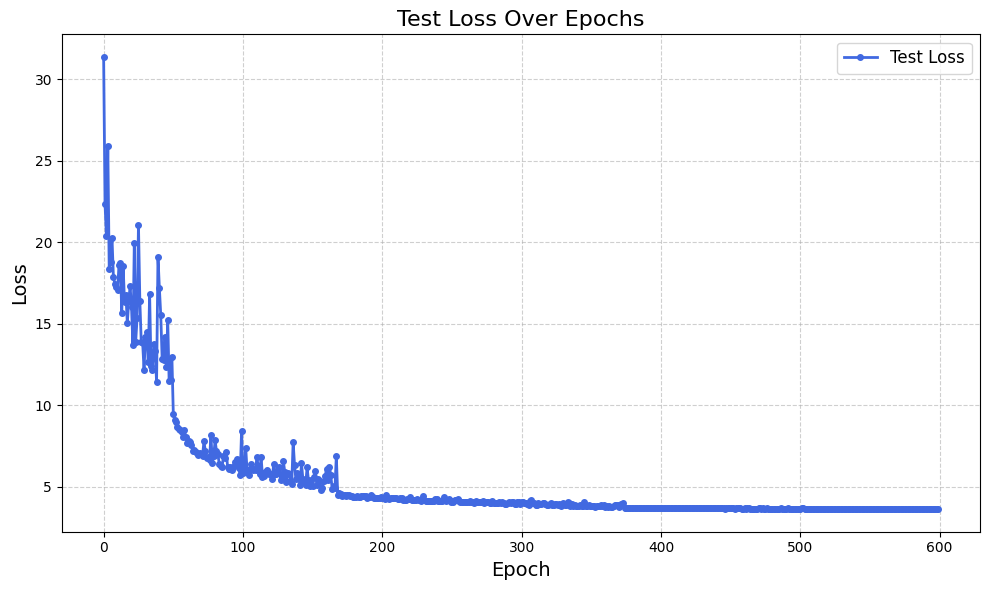

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='royalblue', linewidth=2, marker='o', markersize=4)

plt.title("Test Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("../results/training/Model_A_(NProcs)_test_loss.png", dpi=300)
plt.show()